# Setup

In [63]:
import os
import json
import getpass
import operator

from dotenv import load_dotenv
from typing import TypedDict, Annotated, List, Union
from IPython.display import display, Markdown, clear_output, Image

from langchain_core.agents import AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.agents import AgentAction, AgentFinish

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor

from langchain import hub
from langchain.agents import create_openai_functions_agent

from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
def display_md(md):
    clear_output()
    display(Markdown(md))

def display_json(json_data):
    display_md(f'```json\n{json.dumps(json_data, indent=2)}\n```')

In [3]:
# Set environment variable if not already set
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}")

In [4]:
# Load environment variables from .env file
load_dotenv()

# API keys to check
api_list = [
    "GROQ_API_KEY",
    "TAVILY_API_KEY",
    "LANGCHAIN_API_KEY",
    "OPENAI_API_KEY",
    "LANGCHAIN_TRACING_V2",
    "LANGCHAIN_ENDPOINT",
    "LANGCHAIN_PROJECT"
]

# Check if API keys are set
for api in api_list:
    if os.getenv(api) is None:
        print(f"{api} is not set")
        _set_env(api)
    else:
        print(f"{api} is set")

GROQ_API_KEY is set
TAVILY_API_KEY is set
LANGCHAIN_API_KEY is set
OPENAI_API_KEY is set
LANGCHAIN_TRACING_V2 is set
LANGCHAIN_ENDPOINT is set
LANGCHAIN_PROJECT is set


## Create the LangChain agent

In [6]:
tools = [TavilySearchResults(max_results=1)]

In [59]:
# This script pulls a predefined prompt template from the LangChain Hub and displays it in JSON format.
#
# The prompt template used is "hwchase17/openai-functions-agent", created by Harrison Chase (GitHub username: hwchase17).
# This template is designed to facilitate the creation of agents that utilize OpenAI's function calling capabilities
# to determine and execute actions based on user inputs.
#
# The script performs the following steps:
# 1. Pulls the prompt template from the LangChain Hub using the `hub.pull` method.
# 2. Displays the pulled prompt template in JSON format using the `display_json` method.

prompt = hub.pull("hwchase17/openai-functions-agent")
display_json(prompt.dict())

```json
{
  "name": null,
  "input_variables": [
    "agent_scratchpad",
    "input"
  ],
  "optional_variables": [
    "chat_history"
  ],
  "output_parser": null,
  "partial_variables": {
    "chat_history": []
  },
  "metadata": {
    "lc_hub_owner": "hwchase17",
    "lc_hub_repo": "openai-functions-agent",
    "lc_hub_commit_hash": "a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad689a5"
  },
  "tags": null,
  "messages": [
    {},
    {},
    {},
    {}
  ],
  "validate_template": false,
  "_type": "chat"
}
```

In [60]:
# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [9]:
# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

## Define the graph state

We now define the graph state. The state for the traditional LangChain agent has a few attributes

1. `input`: This is the input string representing the main ask from the user, passed in as input.
2. `chat_history`: This is any previous coversation messages, also passed in as input.
3. `intermediate_steps`: This is list of actions and corresponding observations that the agent takes over time. This is updated each iteration of the agent.
4. `agent_outcome`: This is the response from the agent, either and AgentAction or AgentFinish. the AgentExecutor should finish when this is an AgentFinish, otherwise it should call the requested tools.

In [11]:
class AgentState(TypedDict):
    # The input string
    input: str

    # The list of previous messages in the conversation.
    chat_history: List[BaseMessage]

    # List of actions and corresponding observations
    # Needs 'None' as a valid type, since this is what this will start as.
    agent_outcome: Union[AgentAction, AgentFinish, None]

    # List of actions and corresponding observations
    # Here we annotate this with `operator.add` to indicate that operations to
    # this state should be ADDED to the existing values (not overwrite it)
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph. In `langgraph`, a node can be either a function or a runnable. There are two main nodes we need for this:

  1. The agent responsible for deciding what (if any) actions to take.
  2. A function to invoke tools: if the agent decides to take an action, decides to take an action, this node will then execute that action.

We will also need to define some edges. Some of these edges may be conditional. The reason they are conditional is that based on the output of a node, one of several paths may be taken. The path that is taken is not known until that node is run (the LLM decides).

  1. `Conditional Edge`: After the agent is called, we should either:<br>
     **a.** If the agent said to take an action, they the function to invoke tools should be called<br>
     **b.** If the agent said that it was finished, then it should finish.

  2. `Normal Edge`: After the tools are invoked, it should always go back to the agent to decide what to do next.

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [13]:
# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor(tools)

C:\Users\Makara\AppData\Local\Temp\ipykernel_31416\2850702825.py:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


`run_agent()`

In [14]:
# Define the agent
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {
        "agent_outcome": agent_outcome
    }

`execute_tools()`

In [15]:
# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent outcome - this is the key added in the `agent` above
    agent_action = data["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    return {
        "intermediate_steps": [(agent_action, str(output))]
    }

`should_continue()`

In [16]:
# Define the logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `end` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data["agent_outcome"], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

## Define the Graph

We can now put it all together and define the graph!

In [18]:
# Define a new graph
workflow = StateGraph(AgentState)

In [19]:
# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.env
    # This means these are the edges taken after the `agent` node is called.
    "agent",

    # Next, we pass in the function that will determine which node is called next.
    should_continue,

    # Finally, we pass in the mappting.
    # The keys are strings, and the values are other nodes.
    # END is a special node making that grpah should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

In [23]:
# Finally, we compile it!

# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
app = workflow.compile()

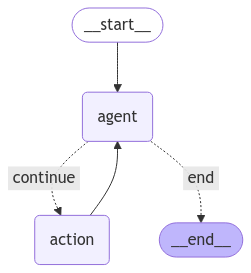

In [65]:
# Display the compiled graph as an image
display(Image(app.get_graph().draw_mermaid_png()))

In [55]:
inputs = {
    "input": "What is the weather in kuliyapitiya sri lanka?",
    "chat_history": []
}
for s in app.stream(inputs):
    outcome = list(s.values())[0]
    print(list(s.values())[0])
    print("------------------------------------------------------------------------")

{'agent_outcome': AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in Kuliyapitiya Sri Lanka'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in Kuliyapitiya Sri Lanka'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in Kuliyapitiya Sri Lanka"}', 'name': 'tavily_search_results_json'}}, response_metadata={'finish_reason': 'function_call', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47'}, id='run-06e8702f-3390-4ccf-9be4-a698f543aa4d-0')])}
------------------------------------------------------------------------
{'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'weather in Kuliyapitiya Sri Lanka'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'weather in Kuliyapitiya Sri Lanka'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'argu

In [56]:
display_md(outcome['agent_outcome'].return_values['output'])

The current weather in Kuliyapitiya, Sri Lanka, is as follows:

- **Temperature**: 25.6°C (78.1°F)
- **Condition**: Patchy rain nearby
- **Wind**: 3.4 mph (5.4 kph) from the East-Southeast
- **Humidity**: 84%
- **Cloud Cover**: 81%
- **Feels Like**: 28.2°C (82.8°F)

For more detailed and updated information, you can visit [WeatherAPI](https://www.weatherapi.com/).